# Using XGBoost Model for longawave estimation of cloud fraction



Objectif : estimate cloud fraction using Temperature, Relative Humidity, Pressure, Gblobal Shortwave, Diffus Shortwave, Direct Shortwave and

Longwave downward as a features and for a model XGBoost

* Before run this code you need to install all the packages needed (Follow the instruction in Readme)


# Function and definition

In [ ]:
# Regular EDA and plotting libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from datetime import date

# We want our plots to appear in the notebook
%matplotlib inline
# plot with higher resolution:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 220

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import plot_importance
from yellowbrick.model_selection import ValidationCurve

## Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix

import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


## plotting pred_CF vs real_CF

This function is use for plotting btoh curve for real values and pedicted values

* data : dataframe containes the predited values and real values

* reference : column name of  real value in data  

* predicted_values : column name of  predited values in data

* start and end : index values to define the range curves to plot

* fig_name : name of the figure to save




In [ ]:
def prediction_CF(data, reference, predicted_values, start,end,fig_name):

    fig, comb = plt.subplots(nrows=1,ncols=1, sharex=True, figsize=(20, 10))

    comb.plot(range(len(data[reference][start:end])),data[predicted_values][start:end], label = predicted_values)

    comb.plot(range(len(data[reference][start:end])),data[reference][start:end], color='r', label = reference)

    comb.set_title("Prediction", fontsize=18)

    comb.axhline(y=data[predicted_values][start:end].mean(), color='b', linestyle='--', label=predicted_values + "_avg")

    comb.axhline(y=data[reference][start:end].mean(), color='r', linestyle='--', label=reference+ "_avg")

    comb.legend(prop={'size':15})

    comb.set_ylabel('Cloud fraction', fontsize=18)

    comb.set_xlabel('Times', fontsize=18)

    comb.tick_params(labelsize=14)

    fig.savefig("curves"+fig_name+".png")

    return data[predicted_values][start:end].mean(),data[reference][start:end].mean()


## GEO_PLOT functions


In [ ]:
def read_csv_into_df_with_header(csv: str):
    """
    and also set datatimeindex csv has to have a column as 'DateTime'
    Parameters
    ----------
    csv :

    Returns
    -------
    pd.DataFrame

    """

    df = pd.read_csv(csv, na_values=['-9999'])

    df['DateTimeIndex'] = pd.to_datetime(df['DateTime'])

    df = df.set_index('DateTimeIndex')
    del df['DateTime']

    # TODO: test todo
    return df

## Prediction
This function performs the prediction and rounds out of range values
in the interval of [0, 1], for the physical definition of cloud fraction.

In [ ]:
def prediction(X_test,model):

    pred_values = (model.predict(X_test)).tolist()

    # Attention: rounds all values to [0, 1]: physics

    for i in range(len(pred_values)):

        pred_values[i] = 1 if pred_values[i] > 1 else pred_values[i]

        pred_values[i] = 0 if pred_values[i] < 0 else pred_values[i]

    return pred_values

## plot model performance vs params


In [ ]:
def plot_model_performance_heatmap(
        cv_results, x_param="learning_rate", y_param="n_estimators",
        score="mean_test_score", title="Heatmap of Model Performance"):
    """
    """

    # definition:
    x_param = f'param_{x_param}'
    y_param = f'param_{y_param}'


    # Convert cv_results to a DataFrame and pivot for heatmap
    results = pd.DataFrame(cv_results)
    pivot_table = results.pivot(index=y_param, columns=x_param, values=score)

    # Plot heatmap with a single colorbar and a label
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': score.replace("_", " ").title()})

    # Add title and labels
    plt.title(title)
    plt.xlabel(x_param.replace("param_", "").replace("_", " ").title())
    plt.ylabel(y_param.replace("param_", "").replace("_", " ").title())
    plt.show()



## plot   overfitting


In [ ]:
def plot_overfitting_heatmap(cv_results, param1, param2, score="mean_test_score", title="Overfitting Heatmap"):
    """
    Plot a heatmap of the difference between training and testing scores to detect overfitting.

    Parameters:
    - cv_results: GridSearchCV results containing training and testing scores.
    - param1: The first hyperparameter to plot along one axis.
    - param2: The second hyperparameter to plot along the other axis.
    - score: The score metric to analyze (default is "mean_test_score").
    - title: Title of the plot.
    """
    # Convert cv_results to DataFrame
    results = pd.DataFrame(cv_results)

    # Calculate the difference between training and testing scores
    results['score_diff'] = results["mean_train_score"] - results["mean_test_score"]

    # Create a pivot table for the score difference
    diff_pivot = results.pivot(index=f'param_{param2}', columns=f'param_{param1}', values="score_diff")

    # Plot heatmap of score difference
    plt.figure(figsize=(8, 6))
    sns.heatmap(diff_pivot, annot=True, fmt=".3f", cmap="coolwarm", center=0,
                cbar_kws={'label': 'Training - Testing Score Difference'})

    # Add title and labels
    plt.title(title)
    plt.xlabel(param1.replace("_", " ").title())
    plt.ylabel(param2.replace("_", " ").title())
    plt.show()


## Function timer

This is a stopwach function for code execution


In [ ]:
def timer(start_time=None):

    from datetime import datetime

    if not start_time:

        start_time = datetime.now()

        return start_time

    elif start_time:

        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)

        tmin, tsec = divmod(temp_sec, 60)

        print('\n Time taken : %i hours %i minutes and %s seconds.' %(thour, tmin, round(tsec, 2)))


## Learning curve

Learning curve is a plot that shows time or experience on the x-axis and learning or improvement on the y-axis. Learning curves are widely used in machine learning for algorithms that learn (optimize their internal parameters) incrementally over time, such as deep learning neural networks. The metric used to evaluate learning could be maximizing, meaning that better scores (larger numbers) indicate more learning. An example would be classification accuracy.

It is more common to use a score that is minimizing, such as loss or error whereby better scores (smaller numbers) indicate more learning and a value of 0.0 indicates that the training dataset was learned perfectly and no mistakes were made. During the training of a machine learning model, the current state of the model at each step of the training algorithm can be evaluated. It can be evaluated on the training dataset to give an idea of how well the model is “learning.” It can also be evaluated on a hold-out validation dataset that is not part of the training dataset. Evaluation on the validation dataset gives an idea of how well the model is “generalizing.”

It is common to create dual learning curves for a machine learning model during training on both the training and validation datasets. The shape and dynamics of a learning curve can be used to diagnose the behavior of a machine learning model, and in turn, perhaps suggest the type of configuration changes that may be made to improve learning and/or performance.

More detail : https://www.geeksforgeeks.org/validation-curve/  

Here we define our leanring curve function:


In [ ]:
def my_learning_curve(model, X_train, X_test, y_train, y_test,fig_name):
    scr_train = round(model.score(X_train, y_train),4)
    scr_test  = round(model.score(X_test, y_test),4)
    y_pred   = model.predict(X_test)

    resultat = model.evals_result()

    plt.figure(figsize=(8, 8))

    plt.plot(resultat['validation_0']['rmse'], label = 'train=%f' %scr_train, color='blue')
    plt.plot(resultat['validation_1']['rmse'], label = 'test=%f' %scr_test, color='red')

    plt.tick_params(labelsize=14)
    plt.ylabel('', fontsize=148)
    plt.xlabel('', fontsize=148)
    plt.title("Learning curve RMSE", fontsize=14)
    plt.legend(prop={'size':15})
    plt.savefig(fig_name + ".png")
    plt.show()


## Validation Curve

A Validation Curve is an important diagnostic tool that shows the sensitivity between to changes in a Machine Learning

model’s accuracy with change in some parameter of the model.

A validation curve is typically drawn between some parameter of the model and the model’s score. Two curves are present

in a validation curve – one for the training set score and one for the cross-validation score. By default, the function

for validation curve, present in the scikit-learn library performs 3-fold cross-validation.

More detail : https://www.geeksforgeeks.org/validation-curve/  

Bellow we define a Validation Curve function with values of k-fold cross validation = 10

In [ ]:
def validation_curve(model, X_train, y_train, hyper_param, param_range):

    viz = ValidationCurve(model, param_name=hyper_param,
                          n_jobs=8, param_range=param_range,
                          cv=10, )

    viz.fit(X_train, y_train)
    viz.show()

## Feature Importance

This refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for dimensionality reduction and feature selection that can improve the efficiency and effectiveness of a predictive model on the problem.

More detail : https://machinelearningmastery.com/calculate-feature-importance-with-python/

Exemple of code for XGBoost : https://mljar.com/blog/feature-importance-xgboost/


In [ ]:
def features_importace(model):

    plot_importance(model)

    pyplot.show()

## Preparing the data

The data preparation is a mandatory for a model machine learning project. We cannot fit and evaluate machine learning algorithms on raw data; instead, we must transform the data to meet the requirements of individual machine learning algorithms. We must choose a representation for the data that best exposes the unknown underlying structure of the prediction problem to the learning algorithms in order to get the best performance given our available resources on a predictive modeling project. The most challenging and big deal part of each predictive modeling project is how to prepare the one thing that is unique to the project: the data used for modeling.

The specific data preparation required for a dataset depends on the specifics of the data, such as the variable types, as well as the algorithms that will be used to model them that may impose expectations or requirements on the data.

There are many technics and common data preparation tasks performed in a predictive modeling machine learning, such as :

* Common Data Preparation Tasks   df  

* Data Cleaning: Identifying and correcting mistakes or errors in the data

* Feature Selection: Identifying those input variables that are most relevant to the task

* Data Transforms: Changing the scale or distribution of variables (It is not necessary for a model based on tree)

* Feature Engineering: Deriving new variables from available data

* Dimensionality Reduction: Creating compact projections of the data

More detail:  

              Book : Machine Learning Mastery

              Title : Data Preparation for Machine Learning Data Cleaning, Feature Selection, and Data Transforms in Python
              
              Author : Jason Brownlee


N.B: In this project big part of the data preparation is done after data quality check imposed by the BSRN community. More detail and source code : https://github.com/LE2P/PyBSRN

## split a data set using train_test_split method from sklearn.model_selection

- data : data set to split
- tst_sz : size of the validation data

N.B: The train_test_split method can be use directly without using this function

In [ ]:
def split(data, tst_sz):
    y = data["CF"]
    X = data.drop("CF" , axis=1)
    # X = X.drop("timestamp" , axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tst_sz, random_state=7)
    return X_train, X_test, y_train, y_test

## upgrade model param

In [ ]:
def upgrade_model(model, param_name, param_value):
    print(f'old {param_name} is: {model.get_params()[param_name]}')
    # upgrade model parameter:
    params = {param_name: param_value}
    model.set_params(**params)
    print(f'new {param_name} is: {model.get_params()[param_name]}')


# start to work



## load data

In [ ]:
# path_data = "/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud/local_data/"
# data_set_name = "DataForML_5min.csv"

path_data = "/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud/dataset/"
data_set_name = './raw.bsrn_lacy.2019_2022.1min.local_time.csv'

# data = pd.read_csv(path_data+data_set_name,delim_whitespace = False)
df_raw = read_csv_into_df_with_header(data_set_name)
print(df_raw.size)
df_raw.corr(method='pearson')

FileNotFoundError: [Errno 2] No such file or directory: './raw.bsrn_lacy.2019_2022.1min.local_time.csv'

## Split data
In this section we split the data into 2 part : one for taining / validation and the seconde is for testing the model for real values.


In [ ]:
# # we have data from 2019-09 to 2022-09 with missing data
# from 2022-01-14 to 2022-05-01, and the month of 2021-08, so that's 2.5 years.
data_for_pred = df_raw['2021-10-01':'2022-09-28']

# print(data_for_test.index)

In [ ]:
# This data set is for taining / validation
train_valid = df_raw['2019-09-13':'2021-09-12']

 Split data set for taining / validation

We split the data set into: X_train, X_test, y_train, y_test by using train_test_split method from sklearn.model_selection.


In [ ]:
# works on two-year data:
X_train, X_test, y_train, y_test=split(train_valid, 0.1)

# predictors = list(df_raw.columns)
# #predictors.remove('P')
# #predictors.remove('RH')
# predictors.remove('CF')

# X_train = df_raw['2019-09-13':'2021-09-12'][predictors]
# y_train = df_raw['2019-09-13':'2021-09-12'][{'CF'}]

# X_test = df_raw['2021-10-01':'2022-09-28'][predictors]
# y_test = df_raw['2021-10-01':'2022-09-28'][{'CF'}]

print(X_train.columns)

print(X_test.shape)
print(X_test)

Index(['GSW', 'SWDir', 'SWDif', 'LWdn', 'T', 'RH', 'P'], dtype='object')
(4803, 7)
                       GSW  SWDir  SWDif   LWdn     T    RH       P
DateTimeIndex                                                      
2019-09-18 14:47:00  530.0  128.0  437.0  388.0  24.5  53.7  1006.0
2019-09-27 09:34:00  625.0  319.0  381.0  400.0  27.1  52.8  1010.0
2019-11-21 16:09:00  635.0  804.0  201.0  412.0  28.4  63.6  1002.0
2019-09-22 12:28:00  999.0  925.0  135.0  348.0  24.5  51.0  1010.0
2019-09-16 11:08:00  621.0  158.0  477.0  399.0  24.6  58.2  1008.0
...                    ...    ...    ...    ...   ...   ...     ...
2019-10-11 08:35:00  616.0  575.0  264.0  357.0  25.1  44.8  1010.0
2019-10-20 14:44:00  806.0  933.0   90.0  357.0  26.3  46.8  1006.0
2019-10-03 09:56:00  826.0  920.0   84.0  370.0  27.0  55.7  1009.0
2019-10-17 09:24:00  714.0  348.0  436.0  380.0  24.4  53.9  1008.0
2019-09-16 15:51:00   49.0    0.0   50.0  415.0  23.2  64.3  1006.0

[4803 rows x 7 columns]


## Default model

Before starting optimizing the model, it is recommended to fit the model with all features and then plot the learnig curve to diagnose the model.


[0]	validation_0-rmse:0.19240	validation_1-rmse:0.19334
[1]	validation_0-rmse:0.12778	validation_1-rmse:0.12877
[2]	validation_0-rmse:0.10388	validation_1-rmse:0.10481
[3]	validation_0-rmse:0.09088	validation_1-rmse:0.09235
[4]	validation_0-rmse:0.08550	validation_1-rmse:0.08727
[5]	validation_0-rmse:0.08205	validation_1-rmse:0.08449
[6]	validation_0-rmse:0.07931	validation_1-rmse:0.08210
[7]	validation_0-rmse:0.07852	validation_1-rmse:0.08146
[8]	validation_0-rmse:0.07599	validation_1-rmse:0.07915
[9]	validation_0-rmse:0.07475	validation_1-rmse:0.07800
[10]	validation_0-rmse:0.07320	validation_1-rmse:0.07655
[11]	validation_0-rmse:0.07221	validation_1-rmse:0.07568
[12]	validation_0-rmse:0.07140	validation_1-rmse:0.07525
[13]	validation_0-rmse:0.06980	validation_1-rmse:0.07375
[14]	validation_0-rmse:0.06875	validation_1-rmse:0.07274
[15]	validation_0-rmse:0.06823	validation_1-rmse:0.07230
[16]	validation_0-rmse:0.06730	validation_1-rmse:0.07147
[17]	validation_0-rmse:0.06648	validation

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:50:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


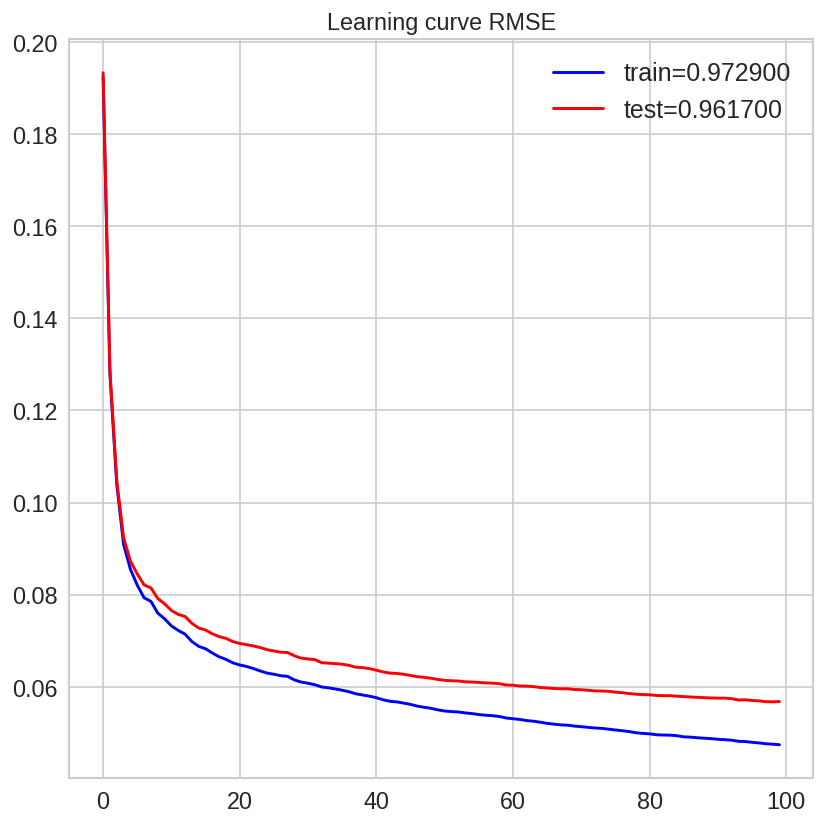

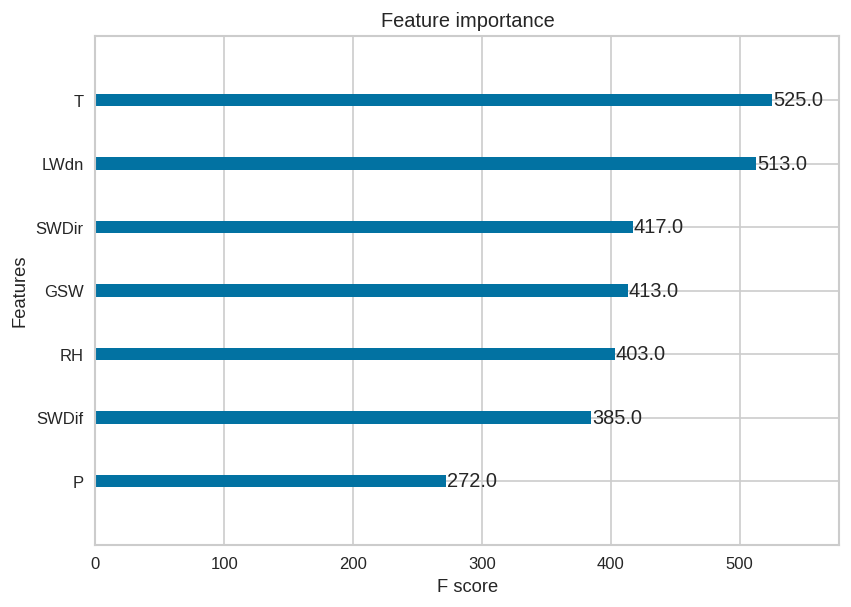

In [ ]:
## Fitting model
evalSet = [(X_train, y_train), (X_test, y_test)]

# default model with experience values:
# Set initial parameters

default_model = XGBRegressor(
    learning_rate=0.5,
    n_estimators = 100,
    max_depth=5,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=0,

    base_score=0.5, booster='gbtree', importance_type='gain', interaction_constraints='',
    # tree_method='exact', # CPU
    # tree_method='gpu_hist',
    device='cuda',
    validate_parameters=1, verbosity=None)

start_times = timer(None)
default_model.fit(X_train, y_train, eval_set=evalSet)

print(f'learning_rate=={default_model.learning_rate}')
print(f'model parameter=={default_model.get_params()}')

## Learning Curve plot with RMSE as a loos function
fig_name="default_model"
my_learning_curve(default_model, X_train, X_test, y_train, y_test,fig_name)
features_importace(default_model)

### Learning curve compared to the amount of data

This curve show us if we have enough data or not for the training

When we observe both curves, we show big gap between both curves and the validation curve (green curve) is still increasing. This mean that we have overfitting and we don't

have enough data for training the model. However, it doesn't mean that we are not able to fit the model with the data and apply tuning hyper parameters techniques.


### Feature importance

Before taking decision about feature engineering part, plotting Feature importance allow us to locate wich features are not important for the model. It can be use to reduce the data dimmensionality.

Generally: Feature Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model.


According to this results, all features are importante for the model to predict the target



### Tuning hyperparameters

By observing Learning curve, we see an overfitting. To solve this issue, we can apply hyper parameter optimizatin technique and feature engineering.

The following step show how to optimize the hyperparameter for XGBoost model.

The model XGBoost has many hyperparameters. In this project we focused on the hyperparameters tightly coupled with our issue.

* N estimators: number of tree

* Learning rate: step size shrinkage

* Max depth: maximum depth of a tree

* Subsample: Subsample ratio of the training instances

* Colsample bylevel: is the subsample ratio of columns for each level

* Colsample bytree: is the subsample ratio of columns when constructing each tree

* Colsample bynodes: is the subsample ratio of columns for each node (split)

* Min child weigth: the minimum sum of instance weight (hessian) needed in a child


# Optimisation method

In a talk by Owen at ODSC Boston 2015 titled Open Source Tools and Data Science Competitions, he summarized common parameters he uses :

* Number of Trees and Learning Rate: Fix the number of trees at around 100 (rather than 1000) and then tune the learning rate.

In our case we chosed n_estimators = 100



* The learning rate parameter can be set to control the weighting of new trees added to the model.

We can use the grid search capability in scikit-learn to evaluate the effect on logarithmic loss of training a gradient boosting model with different learning rate values.

N.B: Smaller learning rates generally require more trees to be added to the model and vice versa.

We chosed some standard learning rate values:

'learning_rate': [0.001, 0.005, 0.01, 0.05]  


In [ ]:
tart_times = timer(None)

param_test1 = {
  'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3],
  # 'n_estimators': [100, 200, 500],

  # 'max_depth': [4, 8, 10, 12],
  # 'min_child_weight': [1, 3, 5, 7],

  # 'gamma': [0, 0.1, 0.2, 0.5, 1],

  # 'subsample': [0.5, 0.7, 0.8, 1],
  # 'colsample_bytree' :[0.5, 0.7, 0.8, 1.0],
}
evalSet = [(X_train, y_train), (X_test, y_test)]

gsearch_1 = GridSearchCV(estimator = default_model,param_grid = param_test1,
                        scoring='neg_root_mean_squared_error', n_jobs=5, cv=10)

gsearch_1.fit(X_train, y_train)

timer(start_times)

gsearch_1.best_params_, gsearch_1.best_score_

 Results
Here we got 'learning_rate' = 0.05 and we can't be sure if this value is appropriate or not. It can be possible that there is an antoher best value more than 0.05.

To solve this problem we will use the function called validataion_curve.


In [ ]:
# dir(gsearch_1)
gsearch_1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
gsearch_1.cv_results_

## learning rate and n_estimators

Let's assign different values for the "learning_rate" parameter : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3] and then plot the validation curve

In [ ]:
start_times = timer(None)

param_test1 = {
  'learning_rate':[0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
  'n_estimators': [100, 200, 500, 1000]
}

evalSet = [(X_train, y_train), (X_test, y_test)]


gsearch_1 = GridSearchCV(estimator=default_model, param_grid=param_test1,
                         scoring='neg_root_mean_squared_error',
                         return_train_score=True,
                         n_jobs=-1, cv=10)

gsearch_1.fit(X_train, y_train)

gsearch_1.best_params_, gsearch_1.best_score_

timer(start_times)

# plot
plot_model_performance_heatmap(gsearch_1.cv_results_,
                               list(param_test1.keys())[0],
                               list(param_test1.keys())[1])
plot_overfitting_heatmap(gsearch_1.cv_results_, list(param_test1.keys())[0],
                               list(param_test1.keys())[1])


 Time taken : 0 hours 7 minutes and 29.18 seconds.

 Time taken : 0 hours 7 minutes and 29.19 seconds.


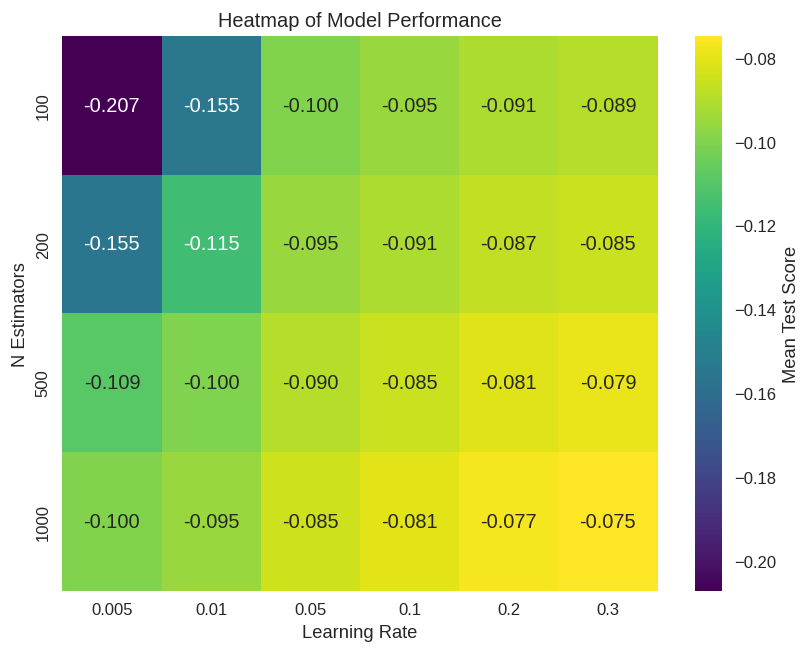

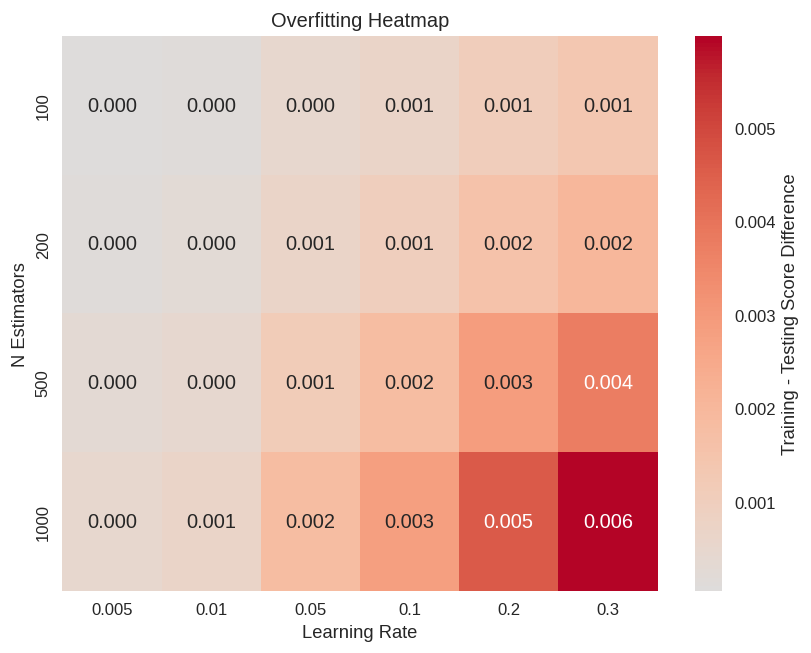

In [ ]:
plot_model_performance_heatmap(gsearch_1.cv_results_,
                               list(param_test1.keys())[0],
                               list(param_test1.keys())[1])
plot_overfitting_heatmap(gsearch_1.cv_results_, list(param_test1.keys())[0],
                               list(param_test1.keys())[1])

old learning_rate is: 0.1
new learning_rate is: 0.1
old n_estimators is: 500
new n_estimators is: 500
0.1
500


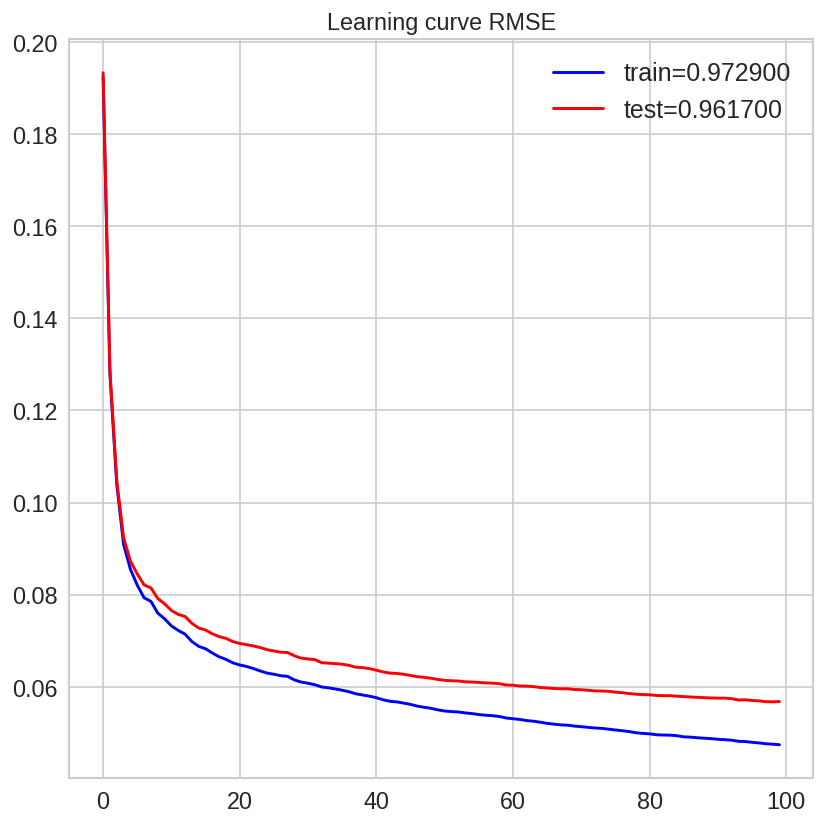

In [ ]:
# upgrade model parameter:
upgrade_model(default_model, 'learning_rate', 0.1)
upgrade_model(default_model, 'n_estimators', 500)
print(default_model.get_params()['learning_rate'])
print(default_model.get_params()['n_estimators'])
my_learning_curve(default_model, X_train, X_test, y_train, y_test,fig_name)

## n_estimator
This parameter allow us to control the size of decision trees. Shallow trees are expected to have poor performance because they capture few details of the problem and are

generally referred to as weak learners. Deeper trees generally capture too many details of the problem and overfit the training dataset, limiting the ability to make good

predictions on new data. We can tune this hyperparameter of XGBoost using the grid search infrastructure in scikit-learn.

The following code show the values chosed:


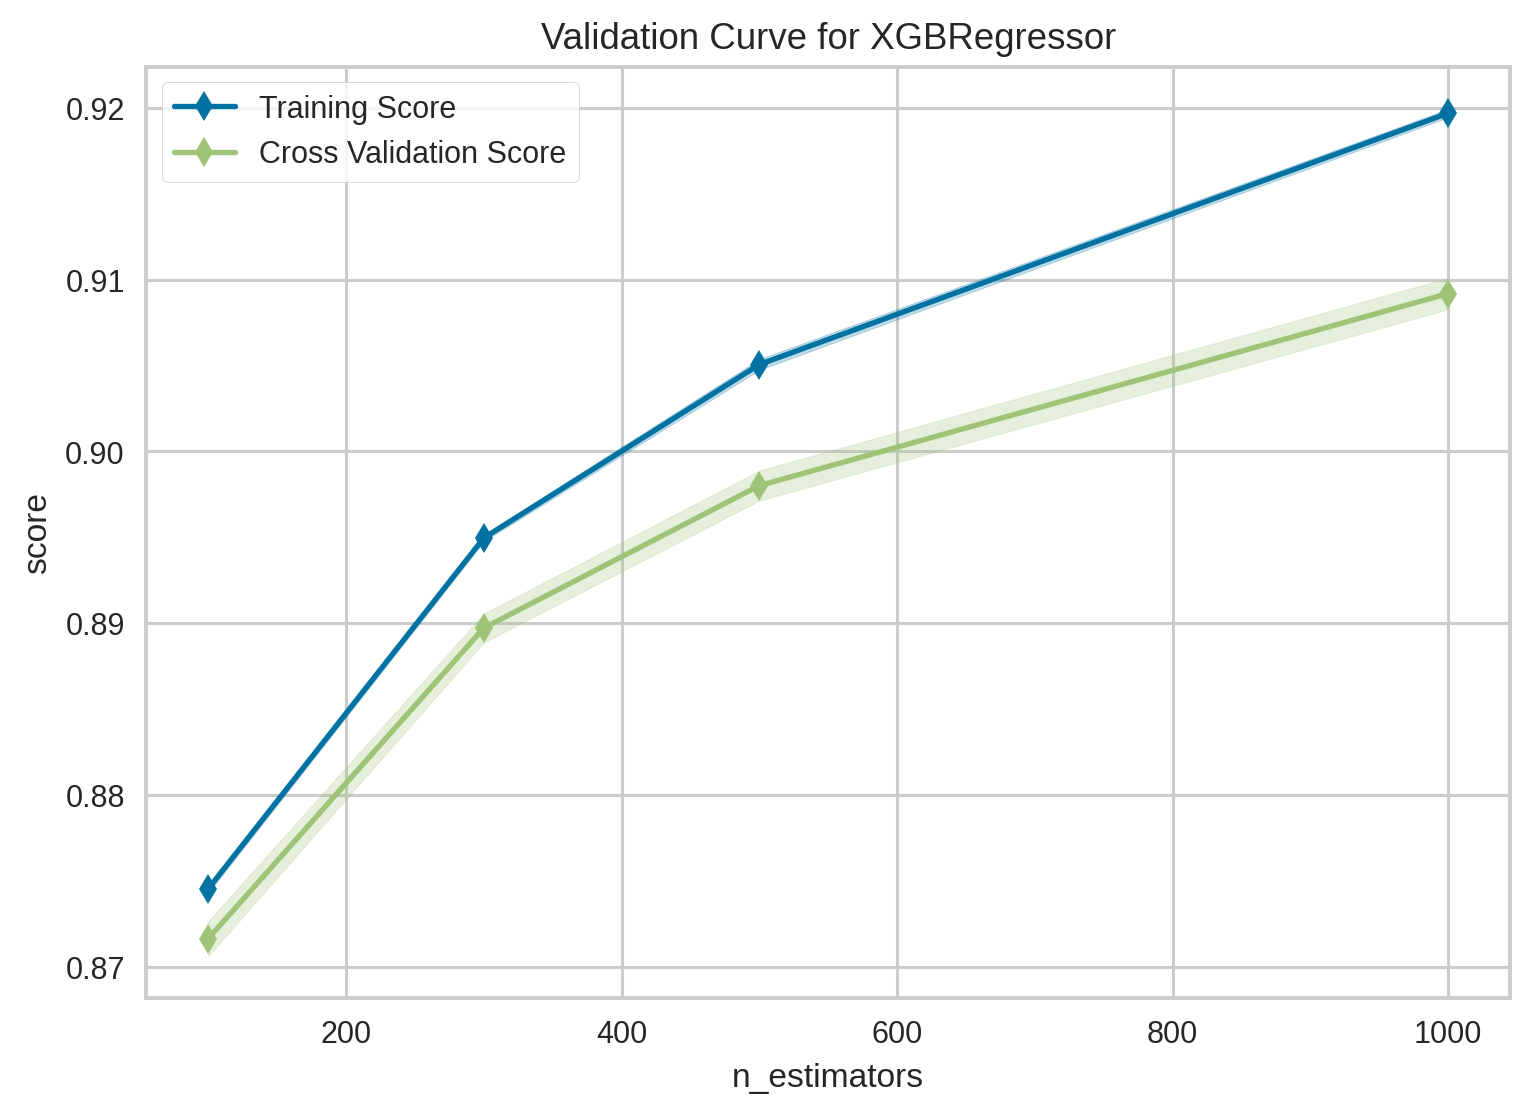


 Time taken : 0 hours 1 minutes and 11.57 seconds.


In [ ]:
start_times = timer(None)

hyper_param = "n_estimators"

param_range = [100, 300, 500, 1000]

validation_curve(default_model, X_train, y_train, hyper_param, param_range)

timer(start_times)

## max_depth
This parameter allow us to control the size of decision trees. Shallow trees are expected to have poor performance because they capture few details of the problem and are

generally referred to as weak learners. Deeper trees generally capture too many details of the problem and overfit the training dataset, limiting the ability to make good

predictions on new data. We can tune this hyperparameter of XGBoost using the grid search infrastructure in scikit-learn.

The following code show the values chosed:


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



 Time taken : 0 hours 18 minutes and 48.41 seconds.


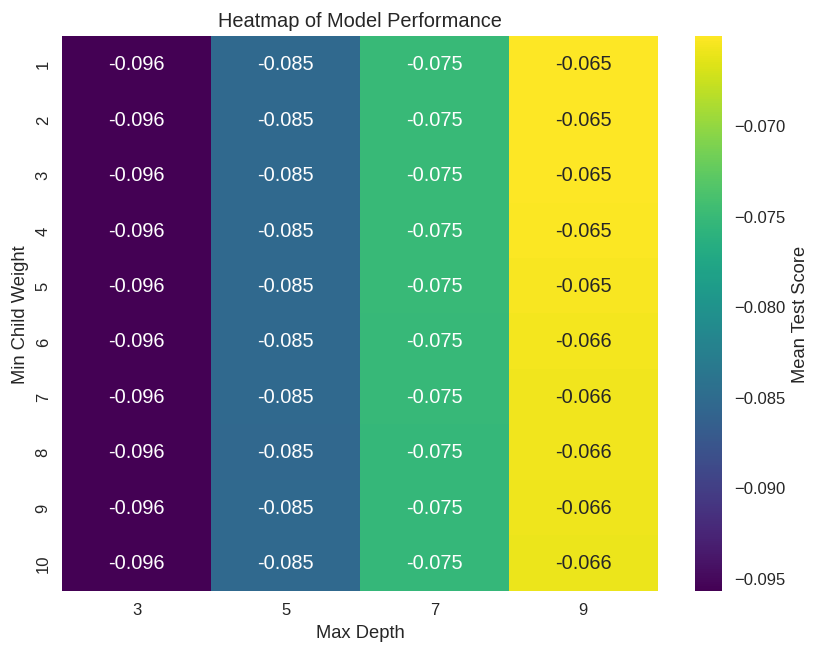

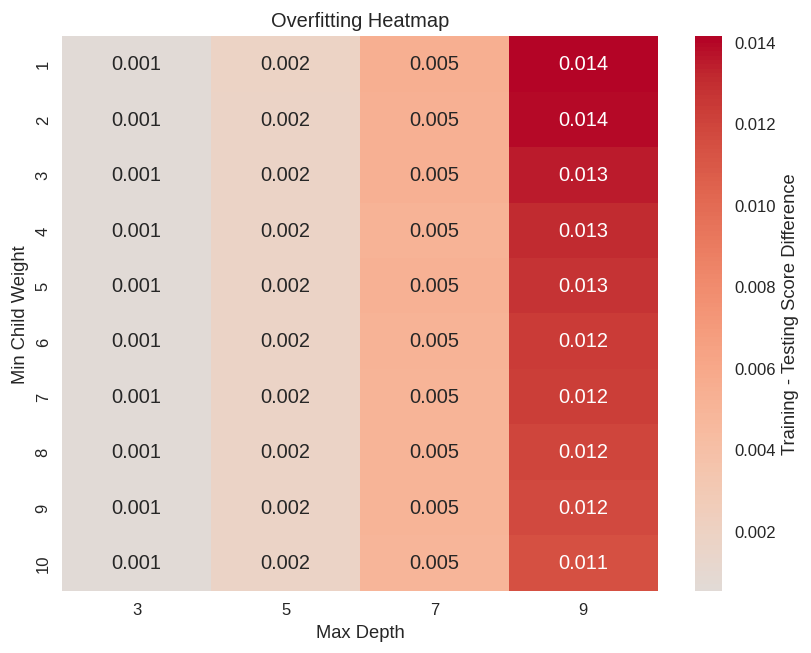

In [ ]:
start_times = timer(None)

param_test1 = {
  'max_depth':[3, 5, 7, 9],
  'min_child_weight':[1,2,3,4,5,6,7,8,9,10]
}

evalSet = [(X_train, y_train), (X_test, y_test)]


gsearch_1 = GridSearchCV(estimator=default_model, param_grid=param_test1,
                         scoring='neg_root_mean_squared_error',
                         return_train_score=True,
                         n_jobs=-1, cv=10)

gsearch_1.fit(X_train, y_train)


gsearch_1.best_params_, gsearch_1.best_score_

timer(start_times)

plot_model_performance_heatmap(gsearch_1.cv_results_,
                               list(param_test1.keys())[0],
                               list(param_test1.keys())[1])
plot_overfitting_heatmap(gsearch_1.cv_results_, list(param_test1.keys())[0],
                               list(param_test1.keys())[1])

The best score was observed for max depth=12. Let's check the validation curve

Reviewing the plot by the validation_curve function, we can see a marked jump from max depth=2 to max depth=12

then pretty even performance for the rest the values of max depth. Although the best score was

observed for max depth=12, it is interesting to note that there was practically little difference between using max depth=11 or max depth=13.

Here we fixe the value of max_depth = 12

old max_depth is: 2
new max_depth is: 5
old min_child_weight is: 20
new min_child_weight is: 20


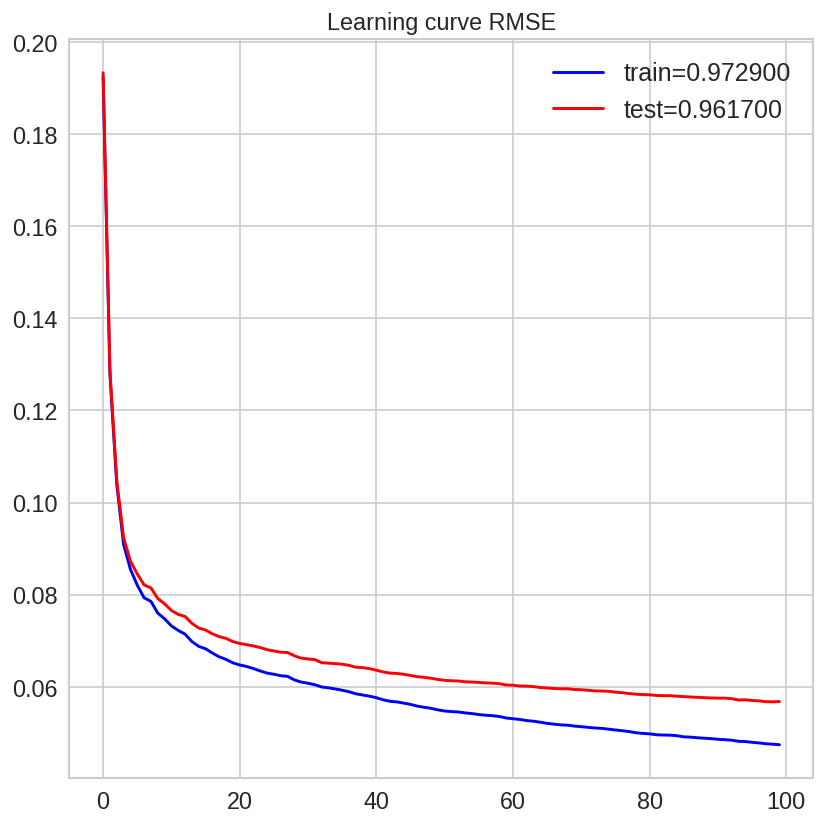

In [ ]:
# upgrade model parameter:
upgrade_model(default_model, 'max_depth', 5)
upgrade_model(default_model, 'min_child_weight', 20)
my_learning_curve(default_model, X_train, X_test, y_train, y_test,fig_name)

##   'colsample_bytree' ,'colsample_bylevel', 'colsample_bynode'

For these 3 hyperparameter we can create a random sample of the features (or columns) to use prior to creating each

decision tree in the boosted model. The default value is 1.0 meaning that all columns are used in each decision tree.

We can evaluate values for colsample bytree between 0.1 and 1.0 incrementing by 0.1.

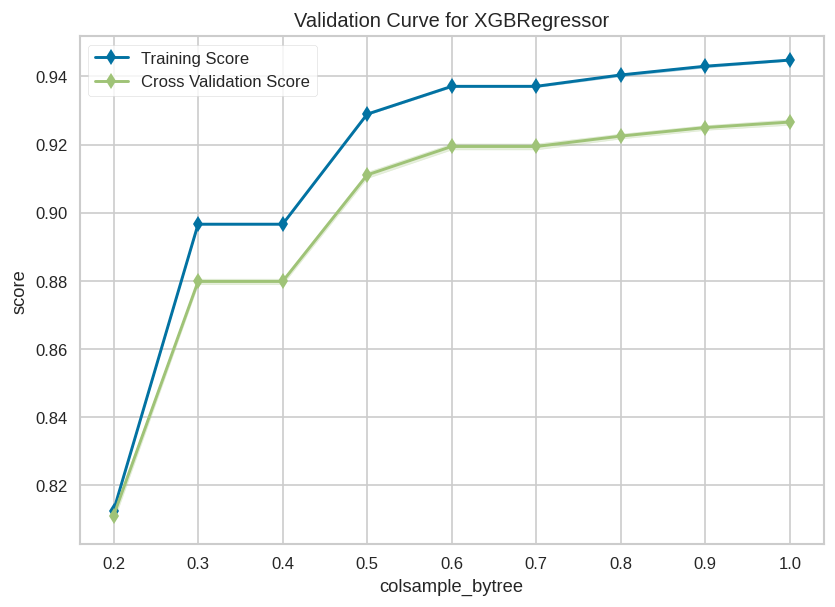


 Time taken : 0 hours 3 minutes and 48.97 seconds.


In [ ]:
start_times = timer(None)

hyper_param = 'colsample_bytree'

param_range = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1.0]

validation_curve(default_model, X_train, y_train, hyper_param, param_range)

timer(start_times)

old colsample_bytree is: 0.8
new colsample_bytree is: 0.6


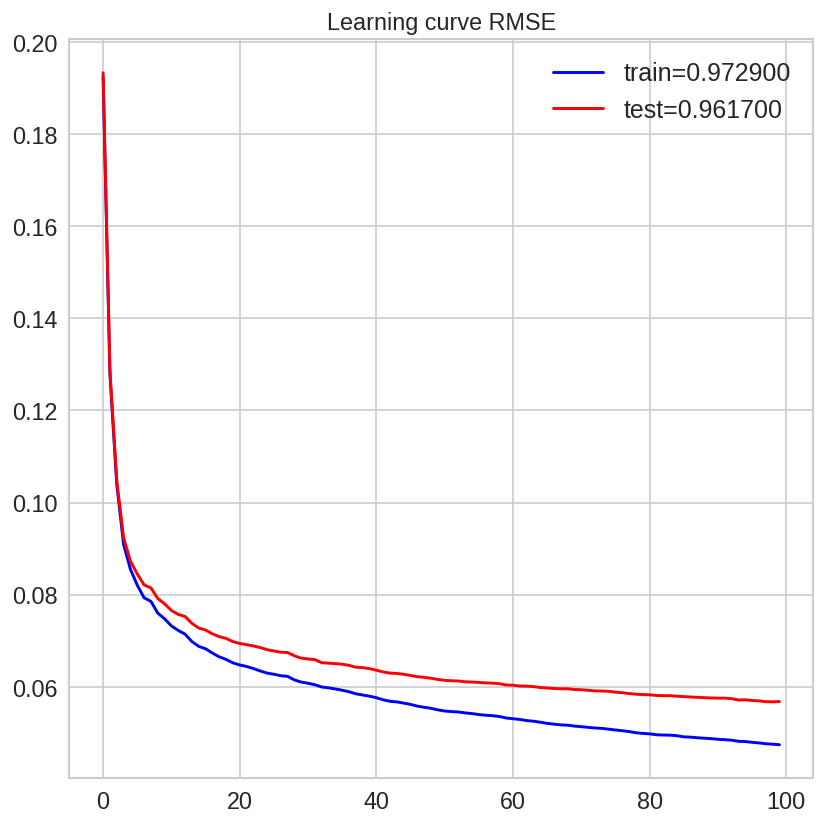

In [ ]:
# upgrade model parameter:
upgrade_model(default_model, 'colsample_bytree', 0.6)
my_learning_curve(default_model, X_train, X_test, y_train, y_test,fig_name)

Plotting the results, we can see the performance of the model  with values 1.0 for 'colsample_bytree', and if we plot the remains we get 'colsample_bylevel' = 0.9 and 'colsample_bynode'= 0.8


## min_child_weight
It defines the minimum sum of weights of all observations required in a child. It is used to control over-fitting, higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can lead to under-fitting.

The larger min_child_weight is, the more conservative the algorithm will be


In [ ]:
start_times = timer(None)

param_test1 = {
  'min_child_weight':[1,2,3,4,5,6,7,8,9,10]
}

evalSet = [(X_train, y_train), (X_test, y_test)]


gsearch_1 = GridSearchCV(estimator = model_tun_lr ,param_grid = param_test1,
                        scoring='neg_root_mean_squared_error', n_jobs=8, cv=10)

gsearch_1.fit(X_train, y_train)

timer(start_times)

gsearch_1.best_params_, gsearch_1.best_score_


 Time taken : 0 hours 2 minutes and 27.15 seconds.


({'min_child_weight': 4}, -0.09558066615204848)

## best_estimator

In [ ]:
gsearch_1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)


 Time taken : 0 hours 0 minutes and 1.24 seconds.


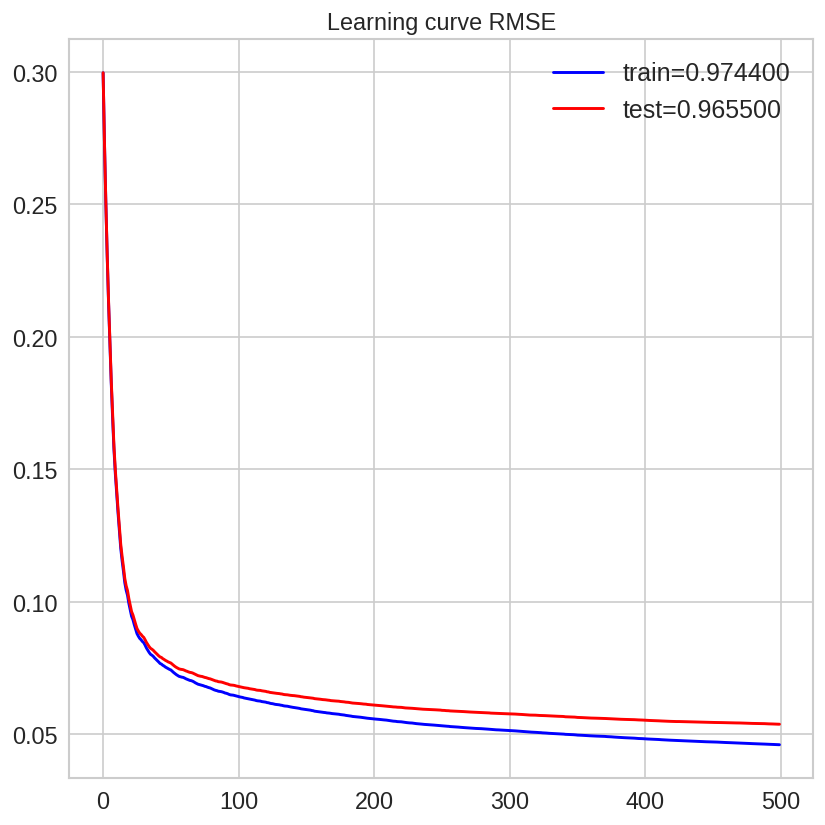

In [ ]:
start_times = timer(None)

evalSet = [(X_train, y_train), (X_test, y_test)]

tuned_model=default_model
tuned_model.fit(X_train, y_train, eval_set=evalSet, verbose=False)

timer(start_times)

fig_name="Without_Pressure"

my_learning_curve(tuned_model, X_train, X_test, y_train, y_test,fig_name)

## Results after optimization

This is the result after changing the value of max_depth to 6. With max_depth = 12 the model is getting overfitting.

Increasing max_depth value will make the model more complex and more likely to overfit. Hence we decrease it to avoid overfitting and we get the figure above.

## plot with data set  test

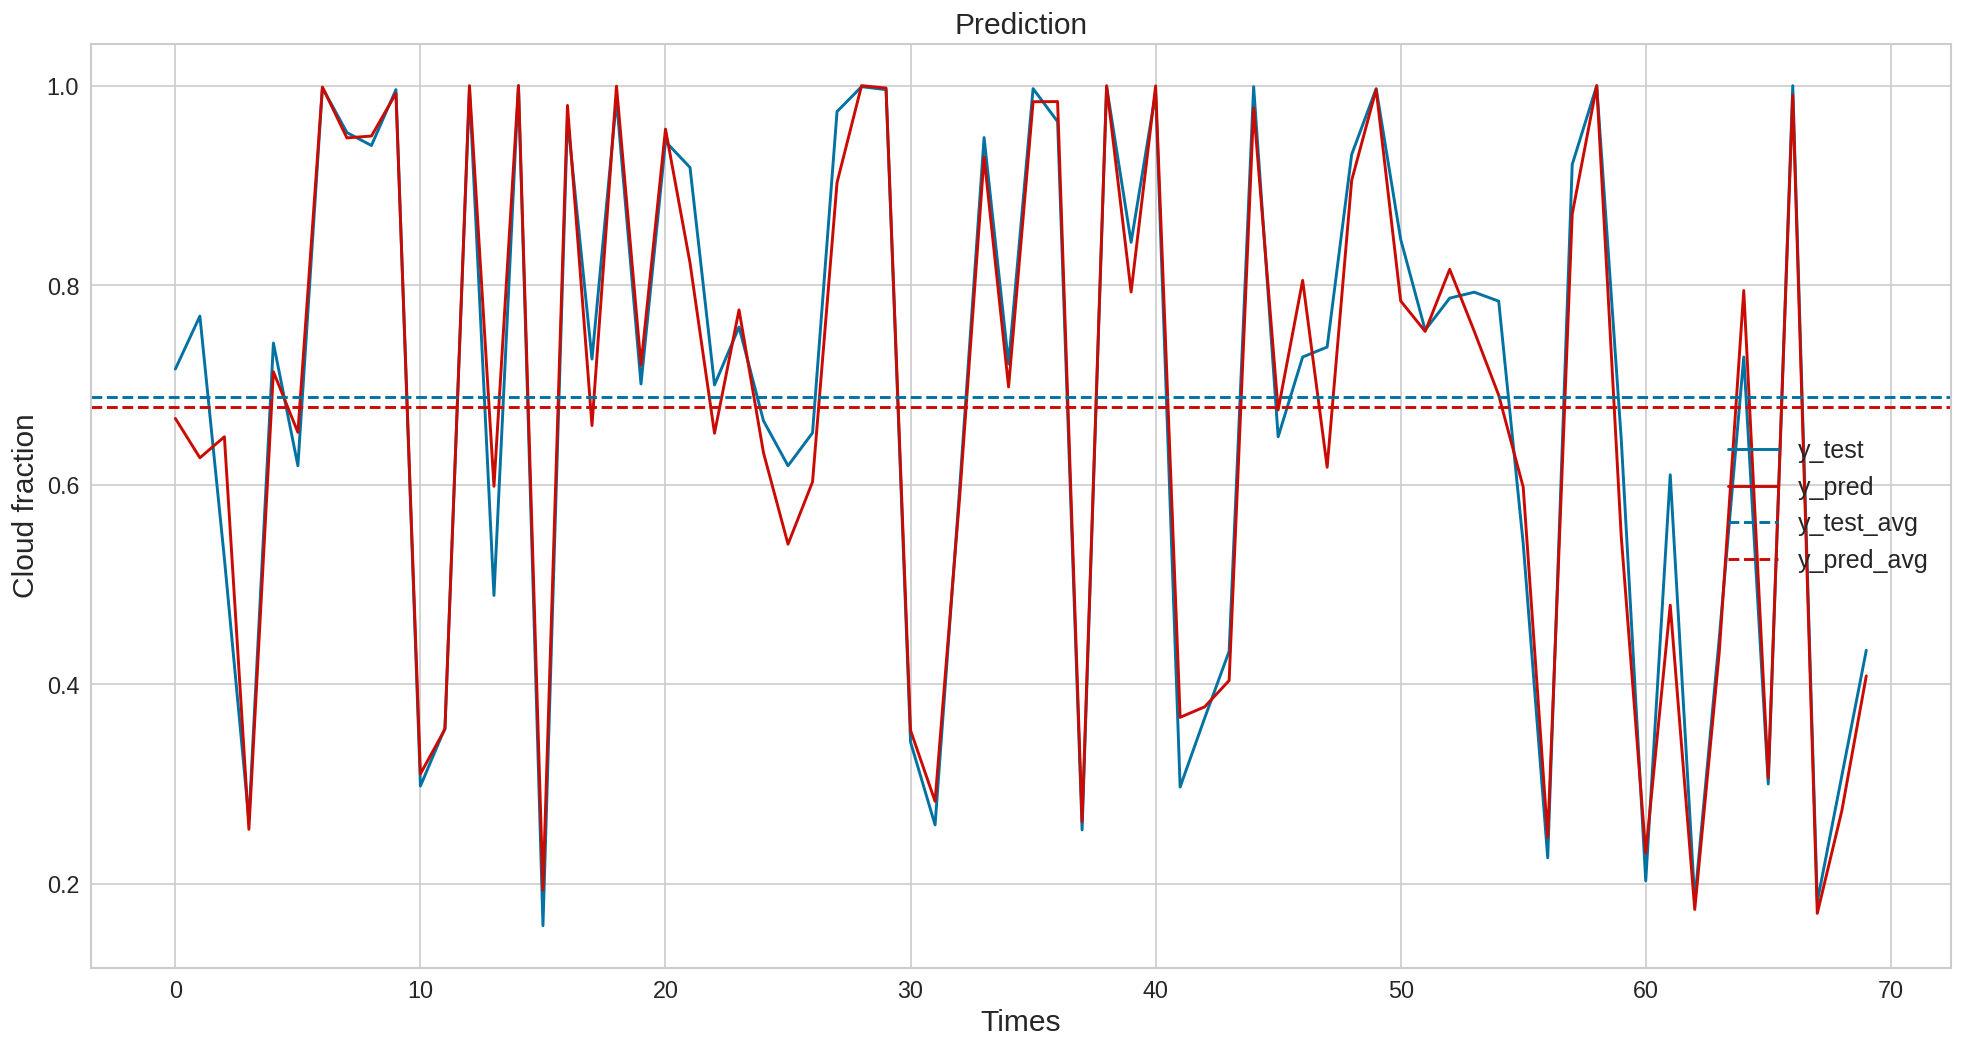

In [ ]:
### Selection
start = 0
end = 70 # 8902
y_pred = prediction(X_test,tuned_model)

data_comp_resutl = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
CF_mean, Prediction_mean = prediction_CF(data_comp_resutl, 'y_pred', 'y_test',start,end, fig_name)

### Plot with real data



## Save model

In [ ]:
import pickle

model_saved = fig_name

pickle.dump(tuned_model, open(model_saved, 'wb'))  # store the model trained

## Load model

In [ ]:
import pickle

model_to_load = fig_name

tuned_model_load = pickle.load(open(model_to_load, 'rb'))